In [ ]:
pip install google-cloud-texttospeech
pip install gtts
pip install pathvalidate

In [169]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from IPython.display import display, Audio, Markdown  
 

In [170]:
import os 
from dotenv import load_dotenv
load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY is not set in the.env file.")

print("API key loaded from.env file.")


API key loaded from.env file.


In [171]:

class State(TypedDict):
    input_text: str
    processed_text: str
    audio_data: bytes
    audio_path: str
    content_type: str
    

class InputState(TypedDict):
    input_text: str
       

In [144]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    api_key=GEMINI_API_KEY,
    model="gemini-1.5-flash",
    temperature=0.3)

In [145]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-692848a4-303b-4496-b8f8-dbe9a234ad2e-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

In [216]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from gtts import gTTS
import tempfile
import io


def classify_content(state: State) -> State:
    messages = [
        SystemMessage(content="Classify the content as one of: 'general', 'poem', 'news', 'joke'."),
        HumanMessage(content=state["input_text"]),
    ] 
    response = llm.invoke(messages) 
    state["content_type"] = response.content.strip().lower()
    return state


def process_general(state: State) -> State:
    messages = [
        SystemMessage(content="Rewrite the following text in a clear, formal, and polished manner:"),
        HumanMessage(content=state["input_text"]),
    ] 
    response = llm.invoke(messages)
    state["processed_text"] = state["input_text"]
    return state


def process_poem(state: State) -> State: 
    messages = [
        SystemMessage(content="Rewrite the following text as a short, beautiful poem:"),
        HumanMessage(content=state["input_text"])
    ]     
    response = llm.invoke(messages)
    state["processed_text"] = response.content.strip()
    return state


def process_news(state: State) -> State: 
    messages = [
        SystemMessage(content="Rewrite the following text in a formal news anchor style:"),
        HumanMessage(content=state["input_text"])
    ] 
    response = llm.invoke(messages) 
    state["processed_text"] = response.content.strip()
    return state


def process_joke(state: State) -> State: 
    messages = [
        SystemMessage(content="Turn the following text into a short, funny joke:"),
        HumanMessage(content=state["input_text"])
    ] 
    response = llm.invoke(messages) 
    state["processed_text"] = response.content.strip()
    return state

def text_to_speech(state: State, save_file: bool = False) -> State:
    language_map = {
        "general": "com.au",   
        "poem": "co.za",      
        "news": "en-us",      
        "joke": "co.in"       
    }
    language = language_map.get(state["content_type"], "en")
 
    tts = gTTS(text=state["processed_text"], lang='en',  tld='co.za',slow=False) 
    audio_data = io.BytesIO()
    tts.write_to_fp(audio_data)
    audio_data.seek(0)   
    state["audio_data"] = audio_data.getvalue() 
    if save_file:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as temp_audio:
            temp_audio.write(state["audio_data"])
            state["audio_path"] = temp_audio.name
    else:
        state["audio_path"] = ""

    return state



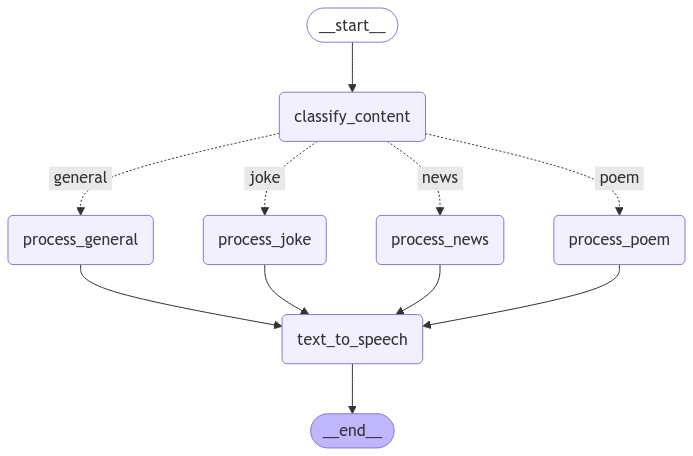

In [217]:

 
workflow:State = StateGraph(State)

workflow.add_node("classify_content", classify_content)
workflow.add_node("process_general", process_general)
workflow.add_node("process_poem", process_poem)
workflow.add_node("process_news", process_news)
workflow.add_node("process_joke", process_joke)
workflow.add_node("text_to_speech", text_to_speech)


workflow.add_edge(START, "classify_content") 
workflow.add_conditional_edges(
    "classify_content",
    lambda x: x["content_type"],
    {
        "general": "process_general",
        "poem": "process_poem",
        "news": "process_news",
        "joke": "process_joke",
    }
) 
workflow.add_edge("process_general", "text_to_speech")
workflow.add_edge("process_poem", "text_to_speech")
workflow.add_edge("process_news", "text_to_speech")
workflow.add_edge("process_joke", "text_to_speech")
workflow.add_edge("text_to_speech", END) 

compiled_workflow = workflow.compile()
display(Image(compiled_workflow.get_graph().draw_mermaid_png()))

In [218]:
def run_tts_agent_and_play(input_text: str):
    result = compiled_workflow.invoke({
        "input_text": input_text, 
        "processed_text": "",
        "audio_data": "",
        "audio_path": "",
        'content_type': "",
    })
    
 
    
    display(Audio(result['audio_data'], autoplay=True))
    return result
 

In [214]:
# Define the text for different contexts
text ="In a surprising turn of events, Donu Drump, a prominent politician in America, has been elected as the president. This marks a significant chapter in the nation's history, as citizens and analysts alike closely watch his tenure unfold."
result = run_tts_agent_and_play(text)


In [215]:
text="Nowadays, America has a well-known politician, Donu Drump, who recently became the president. People are discussing his leadership style and the changes he might bring to the country. "
result = run_tts_agent_and_play(text)

In [221]:
text="""In the land where eagles soar,
A leader rose to take the floor.
Donu Drump, the people's choice,
Now leads the nation with his voice."""
result = run_tts_agent_and_play(text)

In [220]:
text="Did you hear the one about Donu Drump becoming president? They say he’s so popular that even the White House wanted his autograph before he moved in!"
result = run_tts_agent_and_play(text)